In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.sparse as sparse #for numpy.array - pd.dataframe column conversion
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import os, sys, math, json
import warnings
warnings.filterwarnings('ignore')

2024-07-10 17:16:29.605611: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.makedirs('plots', exist_ok=True)
print('Folder ready.')

Folder ready.


## Preparing the dataframe
### Reading the input files

In [3]:
debug = True
nrows_ = None
if debug : nrows_ = 10000

df_gjet = pd.concat([
    pd.read_csv('FlattenedCSVFiles/df_GJet_PT-10to40.csv', nrows=100000),
    pd.read_csv('FlattenedCSVFiles/df_GJet_PT-40.csv', nrows=100000)
])
df_gjet['sample'] = 'gjet'
df_gjet = df_gjet.reset_index(drop=True)

df_qcd = pd.concat([
    pd.read_csv('FlattenedCSVFiles/df_QCD_PT-80to120.csv',     nrows=nrows_),
    pd.read_csv('FlattenedCSVFiles/df_QCD_PT-120to170.csv',    nrows=nrows_),  
    pd.read_csv('FlattenedCSVFiles/df_QCD_PT-170to300.csv',    nrows=nrows_),  
    pd.read_csv('FlattenedCSVFiles/df_QCD_PT-300toInf.csv',    nrows=nrows_),  
])
df_qcd['sample']= 'qcd'
df_qcd = df_qcd.reset_index(drop=True)

df_taugun = pd.concat([
    pd.read_csv('FlattenedCSVFiles/df_TauGun_E-10to100.csv',   nrows=nrows_),  
    pd.read_csv('FlattenedCSVFiles/df_TauGun_E-100to3000.csv', nrows=nrows_),
])
df_taugun['sample'] = 'taugun'
df_taugun = df_taugun.reset_index(drop=True)

print('Files read.')

Files read.


### Defining signal and background

In [4]:
def filter_signal(df):
    # Note: When a candidate matches with a gen-particle, it's genpt is NOT -999
    signal_flag = (~(df['phoMatchingGenPt'] < 0)) & (df['isPromptFinalState'] == 1)
    filtered_df = df[signal_flag]
    return filtered_df

def filter_background(df):
    background_flag1 = (df['phoMatchingGenPt'] < 0) # In case of fakes
    background_flag2 = (~(df['phoMatchingGenPt'] < 0)) & (df['isPromptFinalState'] == 0) # Matches with gen, but non-prompt
    filtered_df = df[background_flag1 | background_flag2]
    return filtered_df
    
df_sig = filter_signal(df_gjet)
df_sig['truth'] = 1 #Target is what the NN tries to predict
df_sig = df_sig.reset_index(drop=True)

df_bkg = pd.concat([filter_background(df_qcd), filter_background(df_taugun)])
df_bkg['truth'] = 0
df_bkg = df_bkg.reset_index(drop=True)

data = pd.concat([df_sig, df_bkg])
data = data[data['phoPt']>10] #Offline Pt cut
data = data.sample(frac=1).reset_index(drop=True) #Randomizing the rows

In [5]:
data[['phoPt','phoEta','phoPhi','phoMatchingGenPt','isPromptFinalState','isPFPhoton','sample','truth']]

,phoPt,phoEta,phoPhi,phoMatchingGenPt,isPromptFinalState,isPFPhoton,sample,truth
0,18.728657,-2.100633,-1.163434,-999.000000,-999,0,qcd,0
1,44.721741,0.200017,-2.281453,45.313488,1,1,gjet,1
2,15.304309,-1.763584,-1.425410,15.807016,0,1,taugun,0
3,26.513182,-2.128407,1.339756,25.682440,1,1,gjet,1
4,37.300701,0.518421,2.483037,36.666073,1,1,gjet,1
...,...,...,...,...,...,...,...,...
161033,81.284378,2.149855,2.537295,81.196388,1,1,gjet,1
161034,77.229057,-0.193224,-1.139364,77.461388,1,1,gjet,1
161035,40.582779,-2.766453,1.479854,24.600531,0,1,taugun,0
161036,16.815624,0.223636,-1.046174,13.897857,0,0,qcd,0


### Filtering against barrel, endcap, or forward region
- For barrel, `abs(eta) < 1.442`
- For endcap, `abs(eta) > 1.566`
- For foward region, `abs(eta) > 2.5`

In [6]:
#Set global parameters here:
model_to_use = 'var11_endcap'
plotinfo = 'forward region [abs(eta) > 2.5]'
figtype = 'forward_unweighted'
data = data[abs(data['phoEta']) > 2.5 ]

data = data.reset_index(drop=True)
print('Dataframe is ready for evaluation.')

nsig = len(data.query('(truth==1)'))
nbkg = len(data.query('(truth==0)'))
nqcd = len(data.query('(sample=="qcd")'))
ntau = len(data.query('(sample=="taugun")'))
frac_qcd = 0
frac_tau = 0
if nbkg !=0 :
    frac_qcd = (nqcd/nbkg)*100
    frac_tau = (ntau/nbkg)*100

print('-'*40)
print('Statistics:')
print(f'nSig = {nsig} (all GJet)')
print(f'nBkg = {nbkg} ({frac_qcd:.1f}% QCD + {frac_tau:.1f}% TauGun)')
print('-'*40)

Dataframe is ready for evaluation.
----------------------------------------
Statistics:
nSig = 9594 (all GJet)
nBkg = 3003 (50.4% QCD + 49.6% TauGun)
----------------------------------------


In [7]:
data.columns

Index(['phoE', 'phoEt', 'phoPt', 'phoEta', 'phoPhi', 'phoHoverE',
       'phoTrkSumPtHollow', 'phoEcalRecHit', 'phoSigmaIEtaIEta3x3',
       'phoSigmaIEtaIPhiFull5x5', 'phoSigmaIEtaIEtaFull5x5',
       'phoEcalPFClusterIso', 'phoHcalPFClusterIso', 'phoHasPixelSeed',
       'phoR93x3', 'phoHcalTower', 'phoHoverECone', 'phoHoverEValid',
       'phoR9Full5x5', 'phoSigmaIPhiIPhiFull5x5', 'phoTrkSumPtSolid',
       'isPromptFinalState', 'isDirectHardProcessTauDecayProductFinalState',
       'isDirectHadronDecayProduct', 'isTauDecayProduct',
       'isPromptTauDecayProduct', 'isDirectTauDecayProduct',
       'isDirectPromptTauDecayProduct',
       'isDirectPromptTauDecayProductFinalState', 'isHardProcess',
       'fromHardProcessFinalState', 'fromHardProcessDecayed',
       'phoMatchingGenPt', 'isPionMother', 'isPFPhoton', 'isPhotonMatching',
       'sample', 'truth'],
      dtype='object')

## Loading the model and the training variables

In [8]:
#varname, min, max, xmin, xmax
# The last two are for plotting
train_var = [
    ("phoHoverE",               5, 6, 0, 0.2),
    ("phoTrkSumPtHollow",       5, 6, 0, 60),
    ("phoEcalRecHit",           5, 6, 0, 60),
    ("phoSigmaIEtaIEta3x3",     5, 6, -0.01, 0.05),
    ("phoSigmaIEtaIEtaFull5x5", 5, 6, -0.01, 0.05),
    ("phoSigmaIEtaIPhiFull5x5", 5, 6, -0.0006, 0.0006), #for barrel
    ("phoEcalPFClusterIso",     5, 6, 0, 60),
    ("phoHcalPFClusterIso",     5, 6, 0, 60),
    ("phoHasPixelSeed",         5, 6, 0, 5),
    ("phoR9Full5x5",            5, 6, 0, 5),
    ("phoHcalTower",            5, 6, 0, 60),
]

#Intializing with max and min values 5,6 in order to find debugs.

jsonfile = 'model_info.json'
with open(jsonfile,'r') as infile: modeldata = json.load(infile)

def load_model(modelname):
    for model, norm in modeldata.items():
        #print(model, modelname)
        if model == modelname:
            print(f'Loading model: {modelname} ...')
            mymodel = tf.keras.models.load_model(f'TrainedModels/{modelname}/{modelname}.h5')
            mymodel.load_weights(f'TrainedModels/{modelname}/{modelname}.h5')
            print('The model is loaded.\n')

            #Updating the min-max scaling numbers:
            for i, (var_code, _, _, xmin, xmax) in enumerate(train_var):
                for var_json, val in norm.items():
                    if var_code == var_json:
                        train_var[i] = (var_code, val['min'], val['max'], xmin, xmax)
                        print(f'{i}. Updated the the min-max values for {var_code}')
            
            return mymodel
    
model = load_model(model_to_use)
print('\nThe following normalizations will be used in the min-max scaler.')
print('Variable'.ljust(29), 'min'.ljust(17), 'max')
for var, min_val, max_val, xmin, xmax in train_var:
    print(f'{var.ljust(30)}{str(min_val).ljust(18)}{str(max_val)}')

Loading model: var11_endcap ...


2024-07-10 17:17:00.927710: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


The model is loaded.

0. Updated the the min-max values for phoHoverE
1. Updated the the min-max values for phoTrkSumPtHollow
2. Updated the the min-max values for phoEcalRecHit
3. Updated the the min-max values for phoSigmaIEtaIEta3x3
4. Updated the the min-max values for phoSigmaIEtaIEtaFull5x5
5. Updated the the min-max values for phoSigmaIEtaIPhiFull5x5
6. Updated the the min-max values for phoEcalPFClusterIso
7. Updated the the min-max values for phoHcalPFClusterIso
8. Updated the the min-max values for phoHasPixelSeed
9. Updated the the min-max values for phoR9Full5x5
10. Updated the the min-max values for phoHcalTower

The following normalizations will be used in the min-max scaler.
Variable                      min               max
phoHoverE                     0.0               0.14999437
phoTrkSumPtHollow             0.0               111922.79
phoEcalRecHit                 0.0               1078.8676
phoSigmaIEtaIEta3x3           0.0               0.074436404
phoSigmaIEtaIE

### Looking at the input variables shapes:

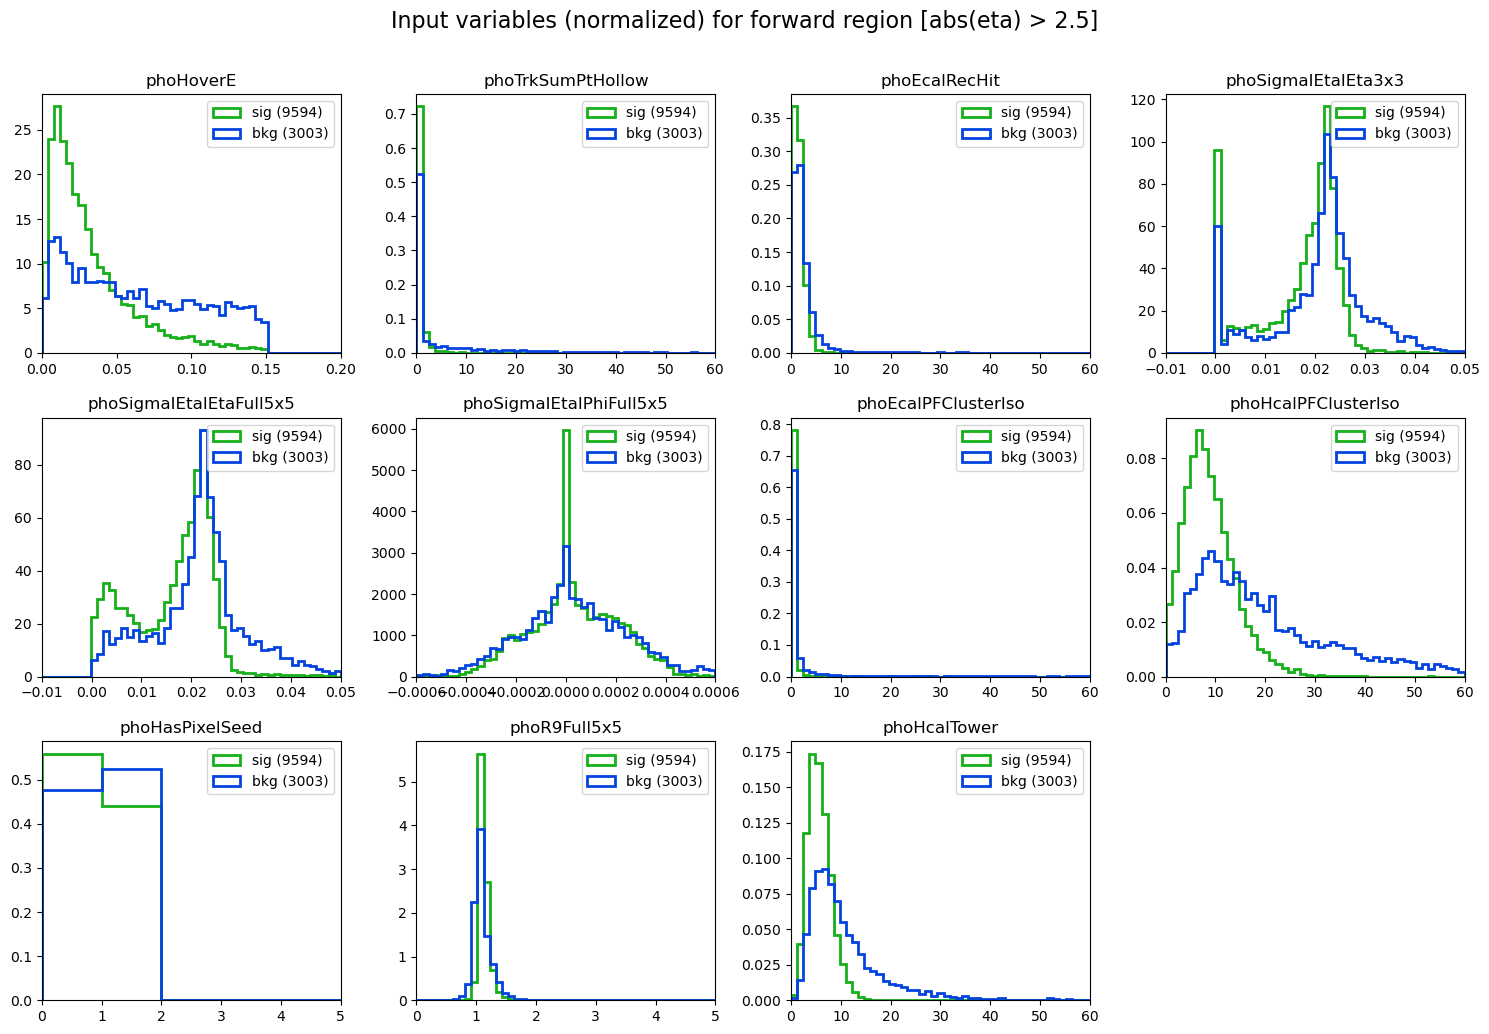

In [16]:
n_cols = 4
n_rows = (len(train_var) + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3.5))
axs = axs.flatten()

for i, (col, _, _, xmin, xmax) in enumerate(train_var):
    ax = axs[i]
    
    #Automatically adjusting bins and x-range:
    sig_data = data[data['truth']==1][col].dropna()
    bkg_data = data[data['truth']==0][col].dropna()
    #min_val = min(sig_data.min(), bkg_data.min())
    #max_val = max(sig_data.max(), bkg_data.max())
    #nbins = np.histogram_bin_edges(np.concatenate((sig_data, bkg_data)), bins='auto').size - 1
    nbins = 50
    mybins = np.linspace(xmin, xmax, nbins)
    
    #Decorations:
    sig_label = f'sig ({len(sig_data)})'
    bkg_label = f'bkg ({len(bkg_data)})'
    sig_color = 'xkcd:green'
    bkg_color = 'xkcd:blue'
    common_hist_props = {
    'histtype': 'step',
    'density': True,
    'linewidth': 2,
    }
    
    #Exceptions:
    if col == 'phoHasPixelSeed' : mybins = np.arange(xmin, xmax + 1, 1)

    ax.hist(sig_data, bins=mybins, label=sig_label, color=sig_color, **common_hist_props)
    ax.hist(bkg_data, bins=mybins, label=bkg_label, color=bkg_color, **common_hist_props)
    ax.set_xlim(xmin, xmax)
    ax.set_title(f'{col}')
    ax.legend(loc='best')

# Remove any unused subplots
for i in range(len(train_var), len(axs)):
    fig.delaxes(axs[i])
    
fig.suptitle(f'Input variables (normalized) for {plotinfo}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.subplots_adjust(hspace=0.25) #do this after tight layout

plt.savefig(f'plots/{figtype}_input_variables.png', dpi=300)
plt.show()

### Preparing normalized X (input parameters) and truth (target) arrays

In [10]:
train_cols = [entry[0] for entry in train_var]
print('The input variables are fed into the neural-network in the following order.')
for i, var in enumerate(train_cols) : print(i, var)

X, y = data[train_cols].values, data[['truth']].values

# Extract min and max values into NumPy arrays
min_values = np.array([entry[1] for entry in train_var])
max_values = np.array([entry[2] for entry in train_var])

def min_max_scaler(X, min_values, max_values):
    MaxMinusMin = max_values - min_values
    normedX = 2 * ((X - min_values) / MaxMinusMin) - 1.0
    return normedX

X = min_max_scaler(X, min_values, max_values)

print('Shapes of the input parameters X and y :')
print(X.shape, y.shape)

The input variables are fed into the neural-network in the following order.
0 phoHoverE
1 phoTrkSumPtHollow
2 phoEcalRecHit
3 phoSigmaIEtaIEta3x3
4 phoSigmaIEtaIEtaFull5x5
5 phoSigmaIEtaIPhiFull5x5
6 phoEcalPFClusterIso
7 phoHcalPFClusterIso
8 phoHasPixelSeed
9 phoR9Full5x5
10 phoHcalTower
Shapes of the input parameters X and y :
(12597, 11) (12597, 1)


### Evaulating the model and looking at the cut-based ID

In [11]:
def get_score_and_roc(model, X, y):
    #Predict using the existing model:
    y_truth = y
    y_predicted = model.predict(X)
    
    fpr, tpr, _ = roc_curve(y_truth, y_predicted) 
    auc_score = auc(tpr,1-fpr)    
    tpr=tpr*100      #True positve rate = How many signal passes the threshold - Signal Efficiency
    fnr=(1-fpr)*100  #False negative rate = How many background fails the threshold - Background Rejection
    
    return y_predicted, fnr, tpr, auc_score

nnscore, fnr, tpr, auc_score = get_score_and_roc(model, X, y)
print('The model is evulated, and TPR, FNR are calculated.')

data["NNScore"] = nnscore
print('The dataframe is updated with the NNscore.')

394/394 [==============================] - 3s 8ms/step
The model is evulated, and TPR, FNR are calculated.
The dataframe is updated with the NNscore.


In [12]:
data[['phoPt','phoEta','phoPhi','phoMatchingGenPt','isPromptFinalState','isPFPhoton','sample','truth','NNScore']]

,phoPt,phoEta,phoPhi,phoMatchingGenPt,isPromptFinalState,isPFPhoton,sample,truth,NNScore
0,190.408859,-2.717509,0.972103,95.351006,0,0,qcd,0,0.000145
1,145.972961,-2.524000,1.493053,143.684647,1,1,gjet,1,0.841201
2,10.243093,2.624040,0.126058,8.398732,0,1,taugun,0,0.295492
3,23.903555,2.529042,0.412120,21.307415,1,0,gjet,1,0.788962
4,27.324093,-2.655801,-2.471326,26.251648,1,0,gjet,1,0.617226
...,...,...,...,...,...,...,...,...,...
12592,87.992546,-2.671662,2.289664,84.984756,1,0,gjet,1,0.764376
12593,90.113640,-2.768021,2.853086,89.916725,1,1,gjet,1,0.688326
12594,26.232283,-2.529932,-1.417394,24.416203,1,1,gjet,1,0.966633
12595,54.249409,-2.558441,0.259454,50.916969,1,1,gjet,1,0.559027


In [13]:
# The cut-based PF-ID :
print('Information on the cut-based ID :')
PF_bkgpass =len(data.query('(isPFPhoton == 1) & (truth == 0)'))
PF_bkgfail =len(data.query('(isPFPhoton == 0) & (truth == 0)'))
PF_sigpass =len(data.query('(isPFPhoton == 1) & (truth == 1)'))
PF_sigfail =len(data.query('(isPFPhoton == 0) & (truth == 1)'))
PF_bkgrej  =( PF_bkgfail/(PF_bkgpass+PF_bkgfail) )*100
PF_sigeff  =( PF_sigpass/(PF_sigpass+PF_sigfail) )*100
print(f'Signal efficiency and background rejection of the cut-based ID : {PF_sigeff:.2f} % and {PF_bkgrej:.2f}%')

Information on the cut-based ID :
Signal efficiency and background rejection of the cut-based ID : 63.36 % and 75.02%


In [14]:
#EGamma working point
wp = 0.80
nn_bkgpass =len(data.query(f'(NNScore > {wp}) & (truth == 0)'))
nn_bkgfail =len(data.query(f'(NNScore < {wp}) & (truth == 0)'))
nn_sigpass =len(data.query(f'(NNScore > {wp}) & (truth == 1)'))
nn_sigfail =len(data.query(f'(NNScore < {wp}) & (truth == 1)'))
nn_bkgrej  =( nn_bkgpass/(nn_bkgpass+nn_bkgfail) )*100
nn_sigeff  =( nn_sigpass/(nn_sigpass+nn_sigfail) )*100
print(f'Signal efficiency and background rejection of the working point: {nn_sigeff:.2f} % and {nn_bkgrej:.2f}%')

Signal efficiency and background rejection of the working point: 35.37 % and 8.49%


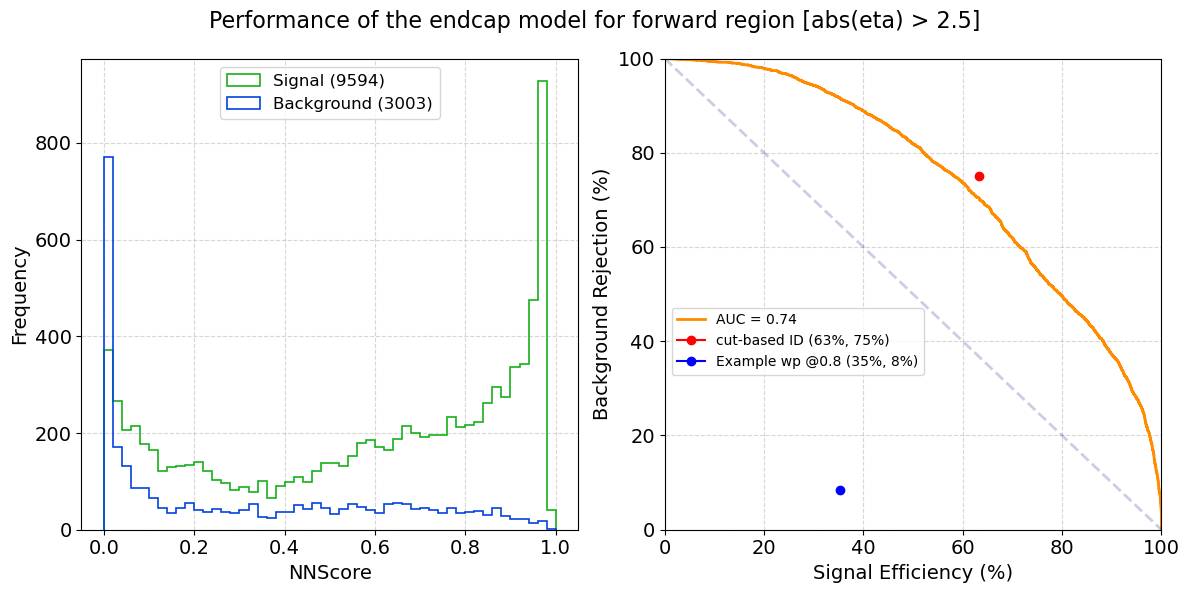

Done!


In [17]:
# Define custom binning for the NNScore
mybins = np.arange(0, 1.02, 0.02)

# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Define common histogram properties
hist_props = {
    'histtype': 'step',
    'density': False,
    'linewidth': 1.2,
}

nsig = len(data[data['truth']==1])
nbkg = len(data[data['truth']==0])
# Left subplot: NNScore distribution
axs[0].hist(data[data['truth']==1]['NNScore'], bins=mybins, color='xkcd:green', label=f'Signal ({nsig})', **hist_props)
axs[0].hist(data[data['truth']==0]['NNScore'], bins=mybins, color='xkcd:blue', label=f'Background ({nbkg})', **hist_props)
axs[0].set_xlabel('NNScore', fontsize=14)
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].grid(True, alpha=0.5, linestyle='--')
axs[0].legend(loc='upper center', fontsize=12)

# Right subplot: ROC curve (assuming you have tpr, fnr, auc_score, PF_sigeff, and PF_bkgrej defined)
axs[1].plot(tpr, fnr, color='darkorange', lw=2, label=f'AUC = {auc_score:.2f}')
axs[1].plot([0, 100], [100, 0], color='navy', lw=2, linestyle='--', alpha=0.2)
axs[1].plot(PF_sigeff, PF_bkgrej, marker='o', color="red",  markersize=6, label=f'cut-based ID ({PF_sigeff:.0f}%, {PF_bkgrej:.0f}%)')
axs[1].plot(nn_sigeff, nn_bkgrej, marker='o', color="blue", markersize=6, label=f'Example wp @{wp} ({nn_sigeff:.0f}%, {nn_bkgrej:.0f}%)')
axs[1].set_xlim([0, 100])
axs[1].set_ylim([0, 100])
axs[1].set_xlabel('Signal Efficiency (%)', fontsize=14)
axs[1].set_ylabel('Background Rejection (%)', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].grid(True, alpha=0.5, linestyle='--')
axs[1].legend(loc='center left', fontsize=10, bbox_to_anchor=(0.0, 0.40))

# Adjust layout
fig.suptitle(f'Performance of the endcap model for {plotinfo}', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.25) #do this after tight layout

# Display the plot after saving.
plt.savefig(f'plots/{figtype}_performance.png', dpi=300)
plt.show()

print('Done!')